# Capstone Project - The Battle of Neighborhoods (Week 2)

# Philadelphia, PA - In and out Food Choice

In [97]:
conda update --name base conda

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [1]:
# The code was removed by Watson Studio for sharing.

In [2]:
import numpy as np 
import pandas as pd 

!conda install -c conda-forge lxml --yes
print("Libraries installed.")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Libraries installed.
Solving environment: done

# All requested packages already installed.

Libraries imported.


# Data about the Philadelphia, PA - Data Cleaning and Wrangling (code hidden).

# The initial data consists of County, Postal code along with Latitude and Logitude from the source CSV file (https://www.opendataphilly.org)

In [3]:
# The code was removed by Watson Studio for sharing.

In [4]:
df_data_1 = pd.read_csv(body)
df_data_1 = df_data_1.rename(columns={'Neighbourhood': 'Neighborhood'})
df_data_1.head(7)


,Neighborhood,PostalCode,Latitude,Longitude
0,Philadelphia,19104,39.957033,-75.210202
1,Philadelphia,19145,39.930332,-75.174720
2,Philadelphia,19106,39.950638,-75.146764
3,Philadelphia,19107,39.957720,-75.157264
4,Philadelphia,19125,39.989663,-75.126142
5,Philadelphia,19130,39.962966,-75.167306
6,Philadelphia,19139,39.966670,-75.245614


In [5]:
df_data_1.shape

(30, 4)

In [6]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

address = 'Philadelphia'

geolocator = Nominatim(user_agent="Philadelphia_food")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinate of Philadelphia are {}, {}.'.format(latitude, longitude))

The geographical coordinate of Philadelphia are 39.9527237, -75.1635262.


In [7]:
map_philadelphia = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to the map
for lat, lng, label in zip(df_data_1['Latitude'], df_data_1['Longitude'], df_data_1['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_philadelphia) 
    
map_philadelphia

# Using Foursquare API, explore cuisine of Philadelphia county

In [8]:
neighborhood_latitude = df_data_1.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude =df_data_1.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = df_data_1.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Philadelphia are 39.957033, -75.210202.


In [32]:
CLIENT_ID = 'XOPYQR1CQN33EEPIBOILK1YSO1N2ZQ3QKKEGBVHG4DQUUQEK' # your Foursquare ID
            
CLIENT_SECRET = 'LERN252LVT1UQOWRTCT2FEQQB4BFLKP2FKC4PKAZJZBSLXBP' # your Foursquare Secret
VERSION = '20200608' # Foursquare API version




In [33]:

LIMIT = 30

radius = 700

url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
phil_results = requests.get(url).json()

In [34]:

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    
    
    venues = results['response']['venues']
    
venues = phil_results['response']['venues']
    
phila_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['name', 'categories', 'location.lat', 'location.lng']
phila_venues = phila_venues.loc[:, filtered_columns]

# filter the category for each row
phila_venues['categories'] = phila_venues.apply(get_category_type, axis=1)

# clean columns
phila_venues.columns = [col.split(".")[-1] for col in phila_venues.columns]
phila_venues.head()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:18: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


,name,categories,lat,lng
0,Fit Gym,Gym / Fitness Center,39.956878,-75.210225
1,New York Gyro Place,Middle Eastern Restaurant,39.956561,-75.209858
2,Kaffa Crossing,Ethiopian Restaurant,39.956738,-75.210411
3,Falafel Exotic Cuisine,Middle Eastern Restaurant,39.956792,-75.209894
4,NY Pizza & Kabob,Pizza Place,39.958408,-75.214249


In [35]:
print("There are a total of "+ str(len(phila_venues["categories"].unique()))+" unique venue categories and "+ str(phila_venues["name"].count()) +" venues in Philadelphia")

There are a total of 23 unique venue categories and 30 venues in Philadelphia


In [36]:
def getNearbyVenues(names, latitudes, longitudes, radius=700):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        #print(url)    
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [37]:
#dataframe to store venue data for each neighborhood, also shows list fo neighborhoods explored by the function call
phila_venues = getNearbyVenues(names=df_data_1['Neighborhood'],
                                   latitudes=df_data_1['Latitude'],
                                   longitudes=df_data_1['Longitude']
                                  )

In [38]:
print(phila_venues.shape)
print("There are a total of "+ str(len(phila_venues["Venue Category"].unique()))+" unique venue categories and "+ str(phila_venues["Venue"].count()) +" venues in Philadelphia")


(747, 7)
There are a total of 176 unique venue categories and 747 venues in Philadelphia


In [39]:
phila_venues.head(5)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Philadelphia,39.957033,-75.210202,Kilimandjaro,39.956563,-75.208964,African Restaurant
1,Philadelphia,39.957033,-75.210202,Manakeesh Cafe Bakery,39.954977,-75.211509,Bakery
2,Philadelphia,39.957033,-75.210202,Saad's Halal Restaurant,39.955067,-75.211846,Middle Eastern Restaurant
3,Philadelphia,39.957033,-75.210202,Kaffa Crossing,39.956738,-75.210411,Ethiopian Restaurant
4,Philadelphia,39.957033,-75.210202,New York Gyro Place,39.956561,-75.209858,Middle Eastern Restaurant


In [40]:
philadelphia_venues_only_restaurant = phila_venues[phila_venues['Venue Category'].str.contains('Restaurant')].reset_index(drop=True)
philadelphia_venues_only_restaurant.index = np.arange(1, len(philadelphia_venues_only_restaurant )+1)
print (philadelphia_venues_only_restaurant['Venue Category'].value_counts())

Mexican Restaurant                 22
Chinese Restaurant                 18
Italian Restaurant                 15
Seafood Restaurant                 14
Vietnamese Restaurant              14
Fast Food Restaurant               12
Mediterranean Restaurant           11
Asian Restaurant                   10
Indian Restaurant                   7
Ethiopian Restaurant                6
Sushi Restaurant                    6
Vegetarian / Vegan Restaurant       6
American Restaurant                 6
Southern / Soul Food Restaurant     5
Middle Eastern Restaurant           5
New American Restaurant             5
Restaurant                          4
Thai Restaurant                     4
Dim Sum Restaurant                  4
Tapas Restaurant                    3
Latin American Restaurant           3
French Restaurant                   3
Caribbean Restaurant                3
Japanese Restaurant                 2
Falafel Restaurant                  2
Ramen Restaurant                    2
Indonesian R

In [41]:
print('There are {} unique categories.'.format(len(philadelphia_venues_only_restaurant['Venue Category'].unique())))

There are 41 unique categories.


In [42]:
# create a dataframe of top 10 categories
phila_Venues_Top10 = philadelphia_venues_only_restaurant['Venue Category'].value_counts()[0:10].to_frame(name='frequency')
phila_Venues_Top10 =phila_Venues_Top10.reset_index()
phila_Venues_Top10 .rename(index=str, columns={"index": "Venue_Category", "frequency": "Frequency"}, inplace=True)
phila_Venues_Top10 

,Venue_Category,Frequency
0,Mexican Restaurant,22
1,Chinese Restaurant,18
2,Italian Restaurant,15
3,Seafood Restaurant,14
4,Vietnamese Restaurant,14
5,Fast Food Restaurant,12
6,Mediterranean Restaurant,11
7,Asian Restaurant,10
8,Indian Restaurant,7
9,Ethiopian Restaurant,6


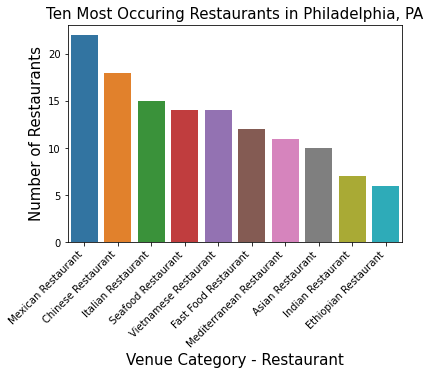

<Figure size 1296x504 with 0 Axes>

In [43]:
import seaborn as sns
from matplotlib import pyplot as plt

s=sns.barplot(x="Venue_Category", y="Frequency", data=phila_Venues_Top10 )
s.set_xticklabels(s.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.title('Ten Most Occuring Restaurants in Philadelphia, PA', fontsize=15)
plt.xlabel("Venue Category - Restaurant", fontsize=15)
plt.ylabel ("Number of Restaurants", fontsize=15)
plt.savefig("Most_Freq_Venues1.png", dpi=300)
fig = plt.figure(figsize=(18,7))
plt.show()

In [44]:
# The code was removed by Watson Studio for sharing.

# Data collecting and wrangling - Counties around Philadelphia, PA

In [45]:

df_data_2 = pd.read_csv(body)
df_data_2 = df_data_2.rename(columns={'Neighbourhood': 'Neighborhood'})
df_data_2.head()

,City,State,Neighborhood,Latitude,Longitude,PostalCode
0,Philadelphia,Pennsylvania,Philadelphia,40.0077,-75.1339,19154
1,Lancaster,Pennsylvania,Lancaster,40.0421,-76.3012,17603
2,Reading,Pennsylvania,Berks,40.3400,-75.9267,19604
3,Pottstown,Pennsylvania,Montgomery,40.2507,-75.6444,19464
4,Levittown,Pennsylvania,Bucks,40.1537,-74.8530,19054


In [46]:
df_data_2.shape

(359, 6)

# Map counties (Philadelphia, Berks, Bucks, Chester, Cumberland, Delaware, Lancaster, Montgomery, Camden (NJ), Salem(NJ)) around Philadelphia, PA

In [47]:
map_philacounties = folium.Map(location=[latitude, longitude], zoom_start=9)

# add markers to the map
for lat, lng, Neigh, city in zip(df_data_2['Latitude'], df_data_2['Longitude'], df_data_2['Neighborhood'], df_data_2['City']):
    
    folium.CircleMarker(
        [lat, lng],
        popup=Neigh,
        color='red',
        fill=True,
        fill_color=Neigh,
        fill_opacity=0.7,
        parse_html=False).add_to(map_philacounties) 
    
map_philacounties

# Using Foursquare API, explore cuisine around other counties

In [48]:
df_data_2.loc[0, 'Neighborhood']

'Philadelphia'

In [49]:
neighborhoodcoun_latitude = df_data_2.loc[0, 'Latitude'] # neighborhood latitude value
neighborhoodcoun_longitude =df_data_2.loc[0, 'Longitude'] # neighborhood longitude value

neighborhoodcoun_name = df_data_2.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Philadelphia are 39.957033, -75.210202.


In [50]:
CLIENT_ID = 'XOPYQR1CQN33EEPIBOILK1YSO1N2ZQ3QKKEGBVHG4DQUUQEK' # your Foursquare ID
            
CLIENT_SECRET = 'LERN252LVT1UQOWRTCT2FEQQB4BFLKP2FKC4PKAZJZBSLXBP' # your Foursquare Secret
VERSION = '20200608' # Foursquare API version

LIMIT = 30

radius = 700

url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhoodcoun_latitude, 
    neighborhoodcoun_longitude, 
    radius, 
    LIMIT)
philcounty_results = requests.get(url).json()



In [51]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    
    
    venues = results['response']['venues']
    
venues = philcounty_results['response']['venues']
    
philacounty_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['name', 'categories', 'location.lat', 'location.lng']
philacounty_venues = philacounty_venues.loc[:, filtered_columns]

# filter the category for each row
philacounty_venues['categories'] = philacounty_venues.apply(get_category_type, axis=1)

# clean columns
philacounty_venues.columns = [col.split(".")[-1] for col in philacounty_venues.columns]
philacounty_venues.head()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:18: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


,name,categories,lat,lng
0,Sunoco,Gas Station,40.007116,-75.137267
1,Roberto Clemente Middle School,Middle School,40.007073,-75.130262
2,St. Christopher's Hospital Heart Center for Ch...,Hospital,40.006852,-75.133328
3,Woodland Building,Hardware Store,40.005861,-75.133376
4,Island Imports,Furniture / Home Store,40.007256,-75.133293


In [ ]:
print("There are a total "+ str(len(philacounty_venues["categories"].unique()))+" unique venue categories and "+ str(philacounty_venues["name"].count()) +" venues around Philadelphia")

In [53]:
#dataframe to store venue data for each neighborhood, also shows list fo neighborhoods explored by the function call
philacounty_venues = getNearbyVenues(names=df_data_2['Neighborhood'],
                                   latitudes=df_data_2['Latitude'],
                                   longitudes=df_data_2['Longitude']
                                  )

In [54]:
print(philacounty_venues.shape)
print("There are a total of "+ str(len(philacounty_venues["Venue Category"].unique()))+" unique venue categories and "+ str(philacounty_venues["Venue"].count()) +" venues around Philadelphia")
philacounty_venues.head(5)

(4008, 7)
There are a total of 331 unique venue categories and 4008 venues around Philadelphia


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Philadelphia,40.0077,-75.1339,Porky's Point Restaurant,40.009825,-75.136486,BBQ Joint
1,Philadelphia,40.0077,-75.1339,Burger King,40.007079,-75.128071,Fast Food Restaurant
2,Philadelphia,40.0077,-75.1339,Citizens Bank,40.011433,-75.135737,Bank
3,Philadelphia,40.0077,-75.1339,Cousin's Supermarket,40.012927,-75.135205,Supermarket
4,Philadelphia,40.0077,-75.1339,KFC,40.012261,-75.135500,Fried Chicken Joint


In [58]:
philadelphiacounty_venues_only_restaurant = philacounty_venues[philacounty_venues['Venue Category'].str.contains('Restaurant')].reset_index(drop=True)
philadelphiacounty_venues_only_restaurant.index = np.arange(1, len(philadelphiacounty_venues_only_restaurant )+1)
print (philadelphiacounty_venues_only_restaurant['Venue Category'].value_counts())

American Restaurant                128
Italian Restaurant                 118
Fast Food Restaurant                61
Chinese Restaurant                  59
Mexican Restaurant                  44
Restaurant                          39
Asian Restaurant                    22
Seafood Restaurant                  18
Japanese Restaurant                 17
Indian Restaurant                   15
Sushi Restaurant                    14
Thai Restaurant                     14
Greek Restaurant                     8
Vegetarian / Vegan Restaurant        8
French Restaurant                    7
Vietnamese Restaurant                7
Mediterranean Restaurant             7
New American Restaurant              6
Southern / Soul Food Restaurant      5
Comfort Food Restaurant              3
German Restaurant                    3
Middle Eastern Restaurant            2
South American Restaurant            2
Dumpling Restaurant                  2
Tapas Restaurant                     2
Korean Restaurant        

In [59]:
print('There are {} unique categories.'.format(len(philadelphiacounty_venues_only_restaurant['Venue Category'].unique())))
print ("Shape of the Data-Frame with Venue Category only Restaurant: ", philadelphiacounty_venues_only_restaurant.shape)
philadelphiacounty_venues_only_restaurant.head(7)

There are 39 unique categories.
Shape of the Data-Frame with Venue Category only Restaurant:  (626, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1,Philadelphia,40.0077,-75.1339,Burger King,40.007079,-75.128071,Fast Food Restaurant
2,Philadelphia,40.0077,-75.1339,Taco Bell,40.012276,-75.135731,Fast Food Restaurant
3,Philadelphia,40.0077,-75.1339,Sunshine Restaurant,40.004257,-75.137230,Spanish Restaurant
4,Lancaster,40.0421,-76.3012,Himalayan Curry & Grill,40.039615,-76.305237,Indian Restaurant
5,Lancaster,40.0421,-76.3012,Belvedere Inn,40.044408,-76.306980,American Restaurant
6,Lancaster,40.0421,-76.3012,Horse Inn,40.042855,-76.294286,American Restaurant
7,Lancaster,40.0421,-76.3012,Barberet,40.038014,-76.304453,French Restaurant


In [60]:
philadelphiacounty_Venues_restaurant = philadelphiacounty_venues_only_restaurant.groupby(['Neighborhood'])['Venue Category'].apply(lambda x: x[x.str.contains('Restaurant')].count())

# Analysis of the neighborhoods.

In [61]:
philadelphiacounty_Venues_restaurant

Neighborhood
Berks            98
Bucks            72
Camden           86
Chester          76
Cumberland       22
Delaware         83
Lancaster        46
Montgomery      137
Philadelphia      3
Salem             3
Name: Venue Category, dtype: int64

In [62]:
philadelphiacounty_Venues_restaurant_df  = philadelphiacounty_Venues_restaurant.to_frame().reset_index()
philadelphiacounty_Venues_restaurant_df.columns = ['Neighborhood', 'Number of Restaurant']
philadelphiacounty_Venues_restaurant.index = np.arange(1, len(philadelphiacounty_Venues_restaurant_df)+1)
list_rest_no =philadelphiacounty_Venues_restaurant_df['Number of Restaurant'].to_list()
list_dist =philadelphiacounty_Venues_restaurant_df['Neighborhood'].to_list()

In [63]:
# one hot encoding
philadelphia_onehot = pd.get_dummies(philadelphiacounty_venues_only_restaurant[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
philadelphia_onehot['Neighborhood'] = philadelphiacounty_venues_only_restaurant['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [philadelphia_onehot.columns[-1]] + list(philadelphia_onehot.columns[:-1])
philadelphia_onehot = philadelphia_onehot[fixed_columns]

philadelphia_onehot.head(5)

,Neighborhood,African Restaurant,American Restaurant,Asian Restaurant,Austrian Restaurant,Brazilian Restaurant,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Comfort Food Restaurant,Dumpling Restaurant,Fast Food Restaurant,Fondue Restaurant,French Restaurant,German Restaurant,Greek Restaurant,Indian Chinese Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,New American Restaurant,Polish Restaurant,Ramen Restaurant,Restaurant,Seafood Restaurant,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sushi Restaurant,Szechuan Restaurant,Tapas Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
1,Philadelphia,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Philadelphia,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Philadelphia,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,Lancaster,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,Lancaster,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [64]:
philadelphia_onehot.shape

(626, 40)

# Grouping by neighborhoods and showing the mean of the frequency of occurence for each category of restaurants.

In [65]:
philadelphia_grouped = philadelphia_onehot.groupby('Neighborhood').mean().reset_index()
philadelphia_grouped

,Neighborhood,African Restaurant,American Restaurant,Asian Restaurant,Austrian Restaurant,Brazilian Restaurant,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Comfort Food Restaurant,Dumpling Restaurant,Fast Food Restaurant,Fondue Restaurant,French Restaurant,German Restaurant,Greek Restaurant,Indian Chinese Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,New American Restaurant,Polish Restaurant,Ramen Restaurant,Restaurant,Seafood Restaurant,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sushi Restaurant,Szechuan Restaurant,Tapas Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Berks,0.010204,0.316327,0.040816,0.000000,0.000000,0.000000,0.000000,0.040816,0.000000,0.000000,0.163265,0.000000,0.010204,0.010204,0.000000,0.000000,0.010204,0.163265,0.000000,0.000000,0.010204,0.010204,0.091837,0.000000,0.000000,0.000000,0.000000,0.051020,0.000000,0.000000,0.000000,0.000000,0.000000,0.020408,0.000000,0.000000,0.020408,0.020408,0.010204
1,Bucks,0.000000,0.263889,0.041667,0.000000,0.000000,0.013889,0.000000,0.041667,0.000000,0.000000,0.041667,0.000000,0.027778,0.013889,0.013889,0.000000,0.027778,0.236111,0.041667,0.000000,0.000000,0.000000,0.041667,0.000000,0.027778,0.000000,0.000000,0.097222,0.013889,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.027778,0.027778,0.000000
2,Camden,0.000000,0.116279,0.046512,0.000000,0.011628,0.000000,0.000000,0.139535,0.023256,0.000000,0.069767,0.000000,0.000000,0.000000,0.000000,0.011628,0.034884,0.220930,0.058140,0.000000,0.000000,0.011628,0.104651,0.000000,0.000000,0.000000,0.000000,0.034884,0.023256,0.011628,0.000000,0.023256,0.000000,0.023256,0.000000,0.000000,0.023256,0.000000,0.011628
3,Chester,0.000000,0.210526,0.013158,0.000000,0.000000,0.000000,0.000000,0.078947,0.000000,0.000000,0.078947,0.000000,0.000000,0.013158,0.026316,0.000000,0.013158,0.250000,0.026316,0.000000,0.000000,0.026316,0.092105,0.000000,0.000000,0.000000,0.013158,0.039474,0.026316,0.000000,0.000000,0.000000,0.000000,0.052632,0.013158,0.013158,0.000000,0.013158,0.000000
4,Cumberland,0.000000,0.318182,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000,0.000000,0.045455,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.136364,0.045455,0.045455,0.000000,0.000000,0.090909,0.045455,0.000000,0.000000,0.000000,0.181818,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,Delaware,0.000000,0.108434,0.048193,0.000000,0.000000,0.000000,0.012048,0.168675,0.000000,0.012048,0.180723,0.000000,0.012048,0.000000,0.036145,0.000000,0.012048,0.144578,0.000000,0.012048,0.000000,0.000000,0.012048,0.000000,0.024096,0.000000,0.000000,0.060241,0.096386,0.000000,0.000000,0.024096,0.000000,0.012048,0.000000,0.000000,0.012048,0.000000,0.012048
6,Lancaster,0.000000,0.347826,0.043478,0.000000,0.000000,0.000000,0.000000,0.086957,0.021739,0.000000,0.086957,0.000000,0.043478,0.000000,0.000000,0.000000,0.021739,0.130435,0.000000,0.000000,0.000000,0.000000,0.043478,0.000000,0.000000,0.000000,0.000000,0.086957,0.000000,0.000000,0.000000,0.000000,0.000000,0.021739,0.000000,0.000000,0.021739,0.021739,0.021739
7,Montgomery,0.000000,0.138686,0.029197,0.007299,0.000000,0.000000,0.000000,0.102190,0.000000,0.007299,0.058394,0.007299,0.007299,0.000000,0.014599,0.000000,0.043796,0.182482,0.043796,0.000000,0.000000,0.021898,0.072993,0.007299,0.014599,0.007299,0.000000,0.058394,0.036496,0.007299,0.007299,0.007299,0.000000,0.029197,0.000000,0.007299,0.043796,0.014599,0.021898
8,Philadelphia,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.666667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0

In [66]:
philadelphia_grouped.shape

(10, 40)

# Print the neighborhoods with their respective top 10 most common venues.

In [67]:
num_top_venues = 10

for hood in philadelphia_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = philadelphia_grouped[philadelphia_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Berks----
                           venue  freq
0            American Restaurant  0.32
1           Fast Food Restaurant  0.16
2             Italian Restaurant  0.16
3             Mexican Restaurant  0.09
4                     Restaurant  0.05
5               Asian Restaurant  0.04
6             Chinese Restaurant  0.04
7  Vegetarian / Vegan Restaurant  0.02
8                Thai Restaurant  0.02
9               Sushi Restaurant  0.02


----Bucks----
                           venue  freq
0            American Restaurant  0.26
1             Italian Restaurant  0.24
2                     Restaurant  0.10
3               Asian Restaurant  0.04
4             Chinese Restaurant  0.04
5             Mexican Restaurant  0.04
6           Fast Food Restaurant  0.04
7            Japanese Restaurant  0.04
8              Indian Restaurant  0.03
9  Vegetarian / Vegan Restaurant  0.03


----Camden----
                  venue  freq
0    Italian Restaurant  0.22
1    Chinese Restaurant  0.14
2   A

# Creating Pandas dataframe

In [68]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [79]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = philadelphia_grouped['Neighborhood']

for ind in np.arange(philadelphia_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(philadelphia_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berks,American Restaurant,Fast Food Restaurant,Italian Restaurant,Mexican Restaurant,Restaurant,Asian Restaurant,Chinese Restaurant,Vegetarian / Vegan Restaurant,Thai Restaurant,Sushi Restaurant
1,Bucks,American Restaurant,Italian Restaurant,Restaurant,Asian Restaurant,Chinese Restaurant,Mexican Restaurant,Fast Food Restaurant,Japanese Restaurant,Indian Restaurant,Vegetarian / Vegan Restaurant
2,Camden,Italian Restaurant,Chinese Restaurant,American Restaurant,Mexican Restaurant,Fast Food Restaurant,Japanese Restaurant,Asian Restaurant,Restaurant,Indian Restaurant,Seafood Restaurant
3,Chester,Italian Restaurant,American Restaurant,Mexican Restaurant,Chinese Restaurant,Fast Food Restaurant,Sushi Restaurant,Restaurant,Japanese Restaurant,Mediterranean Restaurant,Seafood Restaurant
4,Cumberland,American Restaurant,Restaurant,Italian Restaurant,Mexican Restaurant,Chinese Restaurant,Korean Restaurant,Fast Food Restaurant,Japanese Restaurant,Middle Eastern Restaurant,Southern / Soul Food Restaurant


# Clustering the neighborhoods with k-means

In [80]:
# here we will set number of clusters
kclusters = 5

philadelphia_grouped_clustering = philadelphia_grouped.drop('Neighborhood', 1)

# now we will run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(philadelphia_grouped_clustering )

# here we will check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([3, 3, 4, 4, 3, 0, 3, 4, 2, 1], dtype=int32)

In [81]:
phila_merged = df_data_2
phila_merged.head(5)

,City,State,Neighborhood,Latitude,Longitude,PostalCode
0,Philadelphia,Pennsylvania,Philadelphia,40.0077,-75.1339,19154
1,Lancaster,Pennsylvania,Lancaster,40.0421,-76.3012,17603
2,Reading,Pennsylvania,Berks,40.3400,-75.9267,19604
3,Pottstown,Pennsylvania,Montgomery,40.2507,-75.6444,19464
4,Levittown,Pennsylvania,Bucks,40.1537,-74.8530,19054


In [82]:
neighborhoods_venues_sorted_w_clusters = neighborhoods_venues_sorted
neighborhoods_venues_sorted_w_clusters.head(10)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berks,American Restaurant,Fast Food Restaurant,Italian Restaurant,Mexican Restaurant,Restaurant,Asian Restaurant,Chinese Restaurant,Vegetarian / Vegan Restaurant,Thai Restaurant,Sushi Restaurant
1,Bucks,American Restaurant,Italian Restaurant,Restaurant,Asian Restaurant,Chinese Restaurant,Mexican Restaurant,Fast Food Restaurant,Japanese Restaurant,Indian Restaurant,Vegetarian / Vegan Restaurant
2,Camden,Italian Restaurant,Chinese Restaurant,American Restaurant,Mexican Restaurant,Fast Food Restaurant,Japanese Restaurant,Asian Restaurant,Restaurant,Indian Restaurant,Seafood Restaurant
3,Chester,Italian Restaurant,American Restaurant,Mexican Restaurant,Chinese Restaurant,Fast Food Restaurant,Sushi Restaurant,Restaurant,Japanese Restaurant,Mediterranean Restaurant,Seafood Restaurant
4,Cumberland,American Restaurant,Restaurant,Italian Restaurant,Mexican Restaurant,Chinese Restaurant,Korean Restaurant,Fast Food Restaurant,Japanese Restaurant,Middle Eastern Restaurant,Southern / Soul Food Restaurant
5,Delaware,Fast Food Restaurant,Chinese Restaurant,Italian Restaurant,American Restaurant,Seafood Restaurant,Restaurant,Asian Restaurant,Greek Restaurant,Southern / Soul Food Restaurant,New American Restaurant
6,Lancaster,American Restaurant,Italian Restaurant,Fast Food Restaurant,Restaurant,Chinese Restaurant,French Restaurant,Asian Restaurant,Mexican Restaurant,Indian Restaurant,Vietnamese Restaurant
7,Montgomery,Italian Restaurant,American Restaurant,Chinese Restaurant,Mexican Restaurant,Restaurant,Fast Food Restaurant,Thai Restaurant,Japanese Restaurant,Indian Restaurant,Seafood Restaurant
8,Philadelphia,Fast Food Restaurant,Spanish Restaurant,South American Restaurant,Mexican Restaurant,Middle Eastern Restaurant,New American Restaurant,Polish Restaurant,Ramen Restaurant,Restaurant,Seafood Restaurant
9,Salem,American Restaurant,Mexican Restaurant,Italian Restaurant,Mediterranean Restaurant,Middle Eastern Restaurant,New American Restaurant,Polish Restaurant,Ramen Restaurant,Restaurant,Seafood Restaurant


In [83]:
# add clustering labels
neighborhoods_venues_sorted_w_clusters.insert(0, 'Cluster Labels', kmeans.labels_)
neighborhoods_venues_sorted_w_clusters.head(5)

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,3,Berks,American Restaurant,Fast Food Restaurant,Italian Restaurant,Mexican Restaurant,Restaurant,Asian Restaurant,Chinese Restaurant,Vegetarian / Vegan Restaurant,Thai Restaurant,Sushi Restaurant
1,3,Bucks,American Restaurant,Italian Restaurant,Restaurant,Asian Restaurant,Chinese Restaurant,Mexican Restaurant,Fast Food Restaurant,Japanese Restaurant,Indian Restaurant,Vegetarian / Vegan Restaurant
2,4,Camden,Italian Restaurant,Chinese Restaurant,American Restaurant,Mexican Restaurant,Fast Food Restaurant,Japanese Restaurant,Asian Restaurant,Restaurant,Indian Restaurant,Seafood Restaurant
3,4,Chester,Italian Restaurant,American Restaurant,Mexican Restaurant,Chinese Restaurant,Fast Food Restaurant,Sushi Restaurant,Restaurant,Japanese Restaurant,Mediterranean Restaurant,Seafood Restaurant
4,3,Cumberland,American Restaurant,Restaurant,Italian Restaurant,Mexican Restaurant,Chinese Restaurant,Korean Restaurant,Fast Food Restaurant,Japanese Restaurant,Middle Eastern Restaurant,Southern / Soul Food Restaurant


In [84]:
philacounty_merged = phila_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

philacounty_merged.head(5)

,City,State,Neighborhood,Latitude,Longitude,PostalCode,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Philadelphia,Pennsylvania,Philadelphia,40.0077,-75.1339,19154,2,Fast Food Restaurant,Spanish Restaurant,South American Restaurant,Mexican Restaurant,Middle Eastern Restaurant,New American Restaurant,Polish Restaurant,Ramen Restaurant,Restaurant,Seafood Restaurant
1,Lancaster,Pennsylvania,Lancaster,40.0421,-76.3012,17603,3,American Restaurant,Italian Restaurant,Fast Food Restaurant,Restaurant,Chinese Restaurant,French Restaurant,Asian Restaurant,Mexican Restaurant,Indian Restaurant,Vietnamese Restaurant
2,Reading,Pennsylvania,Berks,40.3400,-75.9267,19604,3,American Restaurant,Fast Food Restaurant,Italian Restaurant,Mexican Restaurant,Restaurant,Asian Restaurant,Chinese Restaurant,Vegetarian / Vegan Restaurant,Thai Restaurant,Sushi Restaurant
3,Pottstown,Pennsylvania,Montgomery,40.2507,-75.6444,19464,4,Italian Restaurant,American Restaurant,Chinese Restaurant,Mexican Restaurant,Restaurant,Fast Food Restaurant,Thai Restaurant,Japanese Restaurant,Indian Restaurant,Seafood Restaurant
4,Levittown,Pennsylvania,Bucks,40.1537,-74.8530,19054,3,American Restaurant,Italian Restaurant,Restaurant,Asian Restaurant,Chinese Restaurant,Mexican Restaurant,Fast Food Restaurant,Japanese Restaurant,Indian Restaurant,Vegetarian / Vegan Restaurant


# Examination of five clusters.

# Cluster 0

In [85]:
philacounty_merged.drop(['State', 'State'], axis=1, inplace=True)
philacounty_merged.loc[philacounty_merged['Cluster Labels'] == 0, philacounty_merged.columns[[1] + list(range(5, philacounty_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Delaware,0,Fast Food Restaurant,Chinese Restaurant,Italian Restaurant,American Restaurant,Seafood Restaurant,Restaurant,Asian Restaurant,Greek Restaurant,Southern / Soul Food Restaurant,New American Restaurant
7,Delaware,0,Fast Food Restaurant,Chinese Restaurant,Italian Restaurant,American Restaurant,Seafood Restaurant,Restaurant,Asian Restaurant,Greek Restaurant,Southern / Soul Food Restaurant,New American Restaurant
19,Delaware,0,Fast Food Restaurant,Chinese Restaurant,Italian Restaurant,American Restaurant,Seafood Restaurant,Restaurant,Asian Restaurant,Greek Restaurant,Southern / Soul Food Restaurant,New American Restaurant
21,Delaware,0,Fast Food Restaurant,Chinese Restaurant,Italian Restaurant,American Restaurant,Seafood Restaurant,Restaurant,Asian Restaurant,Greek Restaurant,Southern / Soul Food Restaurant,New American Restaurant
22,Delaware,0,Fast Food Restaurant,Chinese Restaurant,Italian Restaurant,American Restaurant,Seafood Restaurant,Restaurant,Asian Restaurant,Greek Restaurant,Southern / Soul Food Restaurant,New American Restaurant
23,Delaware,0,Fast Food Restaurant,Chinese Restaurant,Italian Restaurant,American Restaurant,Seafood Restaurant,Restaurant,Asian Restaurant,Greek Restaurant,Southern / Soul Food Restaurant,New American Restaurant
30,Delaware,0,Fast Food Restaurant,Chinese Restaurant,Italian Restaurant,American Restaurant,Seafood Restaurant,Restaurant,Asian Restaurant,Greek Restaurant,Southern / Soul Food Restaurant,New American Restaurant
33,Delaware,0,Fast Food Restaurant,Chinese Restaurant,Italian Restaurant,American Restaurant,Seafood Restaurant,Restaurant,Asian Restaurant,Greek Restaurant,Southern / Soul Food Restaurant,New American Restaurant
34,Delaware,0,Fast Food Restaurant,Chinese Restaurant,Italian Restaurant,American Restaurant,Seafood Restaurant,Restaurant,Asian Restaurant,Greek Restaurant,Southern / Soul Food Restaurant,New American Restaurant
45,Delaware,0,Fast Food Restaurant,Chinese Restaurant,Italian Restaurant,American Restaurant,Seafood Restaurant,Restaurant,Asian Restaurant,Greek Restaurant,Southern / Soul Food Restaurant,New American Restaurant


# *Cluster 0 could be Fast Food Restaurant.* 

# Cluster 1

In [86]:
philacounty_merged.loc[philacounty_merged['Cluster Labels'] == 1, philacounty_merged.columns[[1] + list(range(5, philacounty_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
332,Salem,1,American Restaurant,Mexican Restaurant,Italian Restaurant,Mediterranean Restaurant,Middle Eastern Restaurant,New American Restaurant,Polish Restaurant,Ramen Restaurant,Restaurant,Seafood Restaurant
336,Salem,1,American Restaurant,Mexican Restaurant,Italian Restaurant,Mediterranean Restaurant,Middle Eastern Restaurant,New American Restaurant,Polish Restaurant,Ramen Restaurant,Restaurant,Seafood Restaurant
342,Salem,1,American Restaurant,Mexican Restaurant,Italian Restaurant,Mediterranean Restaurant,Middle Eastern Restaurant,New American Restaurant,Polish Restaurant,Ramen Restaurant,Restaurant,Seafood Restaurant
351,Salem,1,American Restaurant,Mexican Restaurant,Italian Restaurant,Mediterranean Restaurant,Middle Eastern Restaurant,New American Restaurant,Polish Restaurant,Ramen Restaurant,Restaurant,Seafood Restaurant
352,Salem,1,American Restaurant,Mexican Restaurant,Italian Restaurant,Mediterranean Restaurant,Middle Eastern Restaurant,New American Restaurant,Polish Restaurant,Ramen Restaurant,Restaurant,Seafood Restaurant
355,Salem,1,American Restaurant,Mexican Restaurant,Italian Restaurant,Mediterranean Restaurant,Middle Eastern Restaurant,New American Restaurant,Polish Restaurant,Ramen Restaurant,Restaurant,Seafood Restaurant
356,Salem,1,American Restaurant,Mexican Restaurant,Italian Restaurant,Mediterranean Restaurant,Middle Eastern Restaurant,New American Restaurant,Polish Restaurant,Ramen Restaurant,Restaurant,Seafood Restaurant


### *Cluster 1 could be American cuisine.* 

# Cluster 2

In [87]:
philacounty_merged.loc[philacounty_merged['Cluster Labels'] == 2, philacounty_merged.columns[[1] + list(range(5, philacounty_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Philadelphia,2,Fast Food Restaurant,Spanish Restaurant,South American Restaurant,Mexican Restaurant,Middle Eastern Restaurant,New American Restaurant,Polish Restaurant,Ramen Restaurant,Restaurant,Seafood Restaurant


# *Cluster 2 could be Fast Food Restaurant.* 

# Cluster 3

In [88]:
philacounty_merged.loc[philacounty_merged['Cluster Labels'] == 3, philacounty_merged.columns[[1] + list(range(5, philacounty_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Lancaster,3,American Restaurant,Italian Restaurant,Fast Food Restaurant,Restaurant,Chinese Restaurant,French Restaurant,Asian Restaurant,Mexican Restaurant,Indian Restaurant,Vietnamese Restaurant
2,Berks,3,American Restaurant,Fast Food Restaurant,Italian Restaurant,Mexican Restaurant,Restaurant,Asian Restaurant,Chinese Restaurant,Vegetarian / Vegan Restaurant,Thai Restaurant,Sushi Restaurant
4,Bucks,3,American Restaurant,Italian Restaurant,Restaurant,Asian Restaurant,Chinese Restaurant,Mexican Restaurant,Fast Food Restaurant,Japanese Restaurant,Indian Restaurant,Vegetarian / Vegan Restaurant
10,Cumberland,3,American Restaurant,Restaurant,Italian Restaurant,Mexican Restaurant,Chinese Restaurant,Korean Restaurant,Fast Food Restaurant,Japanese Restaurant,Middle Eastern Restaurant,Southern / Soul Food Restaurant
11,Cumberland,3,American Restaurant,Restaurant,Italian Restaurant,Mexican Restaurant,Chinese Restaurant,Korean Restaurant,Fast Food Restaurant,Japanese Restaurant,Middle Eastern Restaurant,Southern / Soul Food Restaurant
15,Lancaster,3,American Restaurant,Italian Restaurant,Fast Food Restaurant,Restaurant,Chinese Restaurant,French Restaurant,Asian Restaurant,Mexican Restaurant,Indian Restaurant,Vietnamese Restaurant
20,Lancaster,3,American Restaurant,Italian Restaurant,Fast Food Restaurant,Restaurant,Chinese Restaurant,French Restaurant,Asian Restaurant,Mexican Restaurant,Indian Restaurant,Vietnamese Restaurant
24,Berks,3,American Restaurant,Fast Food Restaurant,Italian Restaurant,Mexican Restaurant,Restaurant,Asian Restaurant,Chinese Restaurant,Vegetarian / Vegan Restaurant,Thai Restaurant,Sushi Restaurant
25,Lancaster,3,American Restaurant,Italian Restaurant,Fast Food Restaurant,Restaurant,Chinese Restaurant,French Restaurant,Asian Restaurant,Mexican Restaurant,Indian Restaurant,Vietnamese Restaurant
26,Berks,3,American Restaurant,Fast Food Restaurant,Italian Restaurant,Mexican Restaurant,Restaurant,Asian Restaurant,Chinese Restaurant,Vegetarian / Vegan Restaurant,Thai Restaurant,Sushi Restaurant


# *Cluster 3 could be American cuisine.* 

# Cluster 4

In [89]:
philacounty_merged.loc[philacounty_merged['Cluster Labels'] == 4, philacounty_merged.columns[[1] + list(range(5, philacounty_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Montgomery,4,Italian Restaurant,American Restaurant,Chinese Restaurant,Mexican Restaurant,Restaurant,Fast Food Restaurant,Thai Restaurant,Japanese Restaurant,Indian Restaurant,Seafood Restaurant
5,Montgomery,4,Italian Restaurant,American Restaurant,Chinese Restaurant,Mexican Restaurant,Restaurant,Fast Food Restaurant,Thai Restaurant,Japanese Restaurant,Indian Restaurant,Seafood Restaurant
8,Montgomery,4,Italian Restaurant,American Restaurant,Chinese Restaurant,Mexican Restaurant,Restaurant,Fast Food Restaurant,Thai Restaurant,Japanese Restaurant,Indian Restaurant,Seafood Restaurant
9,Chester,4,Italian Restaurant,American Restaurant,Mexican Restaurant,Chinese Restaurant,Fast Food Restaurant,Sushi Restaurant,Restaurant,Japanese Restaurant,Mediterranean Restaurant,Seafood Restaurant
12,Montgomery,4,Italian Restaurant,American Restaurant,Chinese Restaurant,Mexican Restaurant,Restaurant,Fast Food Restaurant,Thai Restaurant,Japanese Restaurant,Indian Restaurant,Seafood Restaurant
13,Chester,4,Italian Restaurant,American Restaurant,Mexican Restaurant,Chinese Restaurant,Fast Food Restaurant,Sushi Restaurant,Restaurant,Japanese Restaurant,Mediterranean Restaurant,Seafood Restaurant
14,Montgomery,4,Italian Restaurant,American Restaurant,Chinese Restaurant,Mexican Restaurant,Restaurant,Fast Food Restaurant,Thai Restaurant,Japanese Restaurant,Indian Restaurant,Seafood Restaurant
16,Montgomery,4,Italian Restaurant,American Restaurant,Chinese Restaurant,Mexican Restaurant,Restaurant,Fast Food Restaurant,Thai Restaurant,Japanese Restaurant,Indian Restaurant,Seafood Restaurant
17,Chester,4,Italian Restaurant,American Restaurant,Mexican Restaurant,Chinese Restaurant,Fast Food Restaurant,Sushi Restaurant,Restaurant,Japanese Restaurant,Mediterranean Restaurant,Seafood Restaurant
18,Montgomery,4,Italian Restaurant,American Restaurant,Chinese Restaurant,Mexican Restaurant,Restaurant,Fast Food Restaurant,Thai Restaurant,Japanese Restaurant,Indian Restaurant,Seafood Restaurant


# *Cluster 4 could be Italian cuisine.* 

In [90]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=8.5)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(philacounty_merged['Latitude'], philacounty_merged['Longitude'], philacounty_merged['Neighborhood'], philacounty_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=9,
        popup=label,
        color='black',
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.8).add_to(map_clusters)

map_clusters

# Cluster0 contains Delaware is indicated by red color in the map.  Cluster1 contains Salem(NJ) is indicated by violet color. Cluster2 contains Philadelphia, PA indicates blue color in the map. Cluster3 contains Berks, Bucks, Cumberland and Lancaster counties is indicated by green color. Cluster4 contains Montgomery, Chester, Camden(NJ) is indicated by orange color. 

